## **Project Context and Motivation**

Digital image processing (DIP) forms the foundation of many computer vision applications, long before the rise of machine learning. 
This project revisits classical approaches to image analysis and classification through a real-world use case: traffic sign classification.

### **Importing Libraries**

In [25]:
import os
import sys
import random
import numpy as np 
import cv2
import matplotlib.pyplot as plt
sys.path.append('Image_processing/') 
import preprocessing as pr 

In [26]:
## data directories 
base_dir = 'Data'

# Paths constructed using os.path.join for cross-platform compatibility
data_dir = os.path.join(base_dir, 'Train.csv')
# test_dir = os.path.join(base_dir, 'Train')
filtered_data_dir = os.path.join(base_dir, 'filtered_data.csv')
compiled_original_images_dir = 'images_by_label.npy' ## path to the compiled original images directory

### **Class selection and image reading**

In [27]:
data_csv = np.genfromtxt(data_dir, delimiter=',', dtype=None, encoding=None) # read the csv file
data_csv[:1]

array([['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2',
        'ClassId', 'Path']], dtype='<U30')

In [28]:
data_csv

array([['Width', 'Height', 'Roi.X1', ..., 'Roi.Y2', 'ClassId', 'Path'],
       ['27', '26', '5', ..., '20', '20',
        'Train/20/00020_00000_00000.png'],
       ['28', '27', '5', ..., '22', '20',
        'Train/20/00020_00000_00001.png'],
       ...,
       ['58', '62', '5', ..., '57', '42',
        'Train/42/00042_00007_00027.png'],
       ['63', '69', '5', ..., '63', '42',
        'Train/42/00042_00007_00028.png'],
       ['68', '69', '7', ..., '63', '42',
        'Train/42/00042_00007_00029.png']], shape=(39210, 8), dtype='<U30')

In [29]:
#we are just using 6 unique classes for this 

column_7 = data_csv[:, 6] # get the 7th column of the csv file
unique_classes = np.unique(column_7) # get the unique classes in the 7th column

print("Unique classes in the 7th column: ", unique_classes) # print the unique classes

Unique classes in the 7th column:  ['0' '1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21'
 '22' '23' '24' '25' '26' '27' '28' '29' '3' '30' '31' '32' '33' '34' '35'
 '36' '37' '38' '39' '4' '40' '41' '42' '5' '6' '7' '8' '9' 'ClassId']


run these lines to select different random classes to run the script on otherwise, keep them commented

In [30]:
# # randomly select 6 unique classes from the unique classes
# selected_classes = random.sample(list(unique_classes), 6) # select 6 unique classes

In [31]:
# selected_classes

In [32]:
# ##saving the selected classes to a text file
# with open('selected_classes.txt', 'w') as f:
#     for item in selected_classes:
#         f.write("%s\n" % item)

In [33]:
selected_classes_path = os.path.join('Data', 'selected_classes.txt')
selected_classes = np.genfromtxt(selected_classes_path, dtype=str)

In [34]:
selected_classes 

array(['33', '26', '24', '9', '0', '4'], dtype='<U2')

In [35]:
# filter the data to only include the selected classes
filtered_data = data_csv[np.isin(data_csv[:, 6], selected_classes)] 
# removing the header row 
filtered_data = filtered_data[1:] 

In [36]:
np.unique(filtered_data[:,6]) # additional check to see if the filtered data has the selected classes

array(['0', '24', '26', '33', '4', '9'], dtype='<U30')

In [37]:
# we only need class ID and image path for the filtered data
filtered_data = filtered_data[:, -2:]
for row in filtered_data:
    print('\t'.join(row))

0	Train/0/00000_00000_00001.png
0	Train/0/00000_00000_00002.png
0	Train/0/00000_00000_00003.png
0	Train/0/00000_00000_00004.png
0	Train/0/00000_00000_00005.png
0	Train/0/00000_00000_00006.png
0	Train/0/00000_00000_00007.png
0	Train/0/00000_00000_00008.png
0	Train/0/00000_00000_00009.png
0	Train/0/00000_00000_00010.png
0	Train/0/00000_00000_00011.png
0	Train/0/00000_00000_00012.png
0	Train/0/00000_00000_00013.png
0	Train/0/00000_00000_00014.png
0	Train/0/00000_00000_00015.png
0	Train/0/00000_00000_00016.png
0	Train/0/00000_00000_00017.png
0	Train/0/00000_00000_00018.png
0	Train/0/00000_00000_00019.png
0	Train/0/00000_00000_00020.png
0	Train/0/00000_00000_00021.png
0	Train/0/00000_00000_00022.png
0	Train/0/00000_00000_00023.png
0	Train/0/00000_00000_00024.png
0	Train/0/00000_00000_00025.png
0	Train/0/00000_00000_00026.png
0	Train/0/00000_00000_00027.png
0	Train/0/00000_00000_00028.png
0	Train/0/00000_00000_00029.png
0	Train/0/00000_00001_00000.png
0	Train/0/00000_00001_00001.png
0	Train/

**Limiting the Data to only 100 images per class**

In [38]:
limited_data = []
header, rows = data_csv[0], data_csv[1:]
filtered_rows = rows[np.isin(rows[:, 6], selected_classes)]

for cls in selected_classes:
    class_rows = filtered_rows[filtered_rows[:, 6] == cls]
    limited_data.append(class_rows[:100])

limited_data = np.vstack(limited_data)  # combine into one array
limited_data = limited_data[:, -2:]     # take only last two columns

print(f"Limited Data Shape:\n{limited_data.shape}")


Limited Data Shape:
(600, 2)


## Preprocessing the images

In [53]:
def read_csv(file_path, base_dir=''):
    data = np.genfromtxt(file_path, delimiter=',', dtype=None, encoding='utf-8-sig')

    # Dictionary to store images grouped by label
    images_by_label = {}

    for row in data[1:]:  # Skip header
        label = row[0]
        image_path = os.path.normpath(row[1])  # Normalize the path
        full_image_path = os.path.normpath(os.path.join(base_dir, image_path))
        #print(full_image_path, os.path.exists(full_image_path))
        if label not in images_by_label:
            images_by_label[label] = []

        images_by_label[label].append({
            "path": image_path,
            "image": cv2.imread(full_image_path)
        })
    return images_by_label

In [54]:
images = read_csv(filtered_data_dir)
np.save('images_by_label.npy', images) # save the original compiled images to a numpy file

In [108]:
## applying the filter to the images 
filters = {
    'mean': pr.mean_filter,
    'gaussian': lambda img: pr.gaussian_filter(img, sigma=1.0),
    'median': pr.median_filter,
    'adaptive_median': pr.adaptive_median_filter,
    'unsharp': pr.unsharp_mask
}
processed_images = {}

for label, image_list in images.items():
    processed_images[label] = {}
    for filter_name, filter_fn in filters.items():
        processed_images[label][filter_name] = []  # list of processed images
        for entry in image_list:
            original_img = entry['image']
            filtered_img = filter_fn(original_img)
            processed_images[label][filter_name].append({
                'path': entry['path'],
                'filtered_image': filtered_img
            })

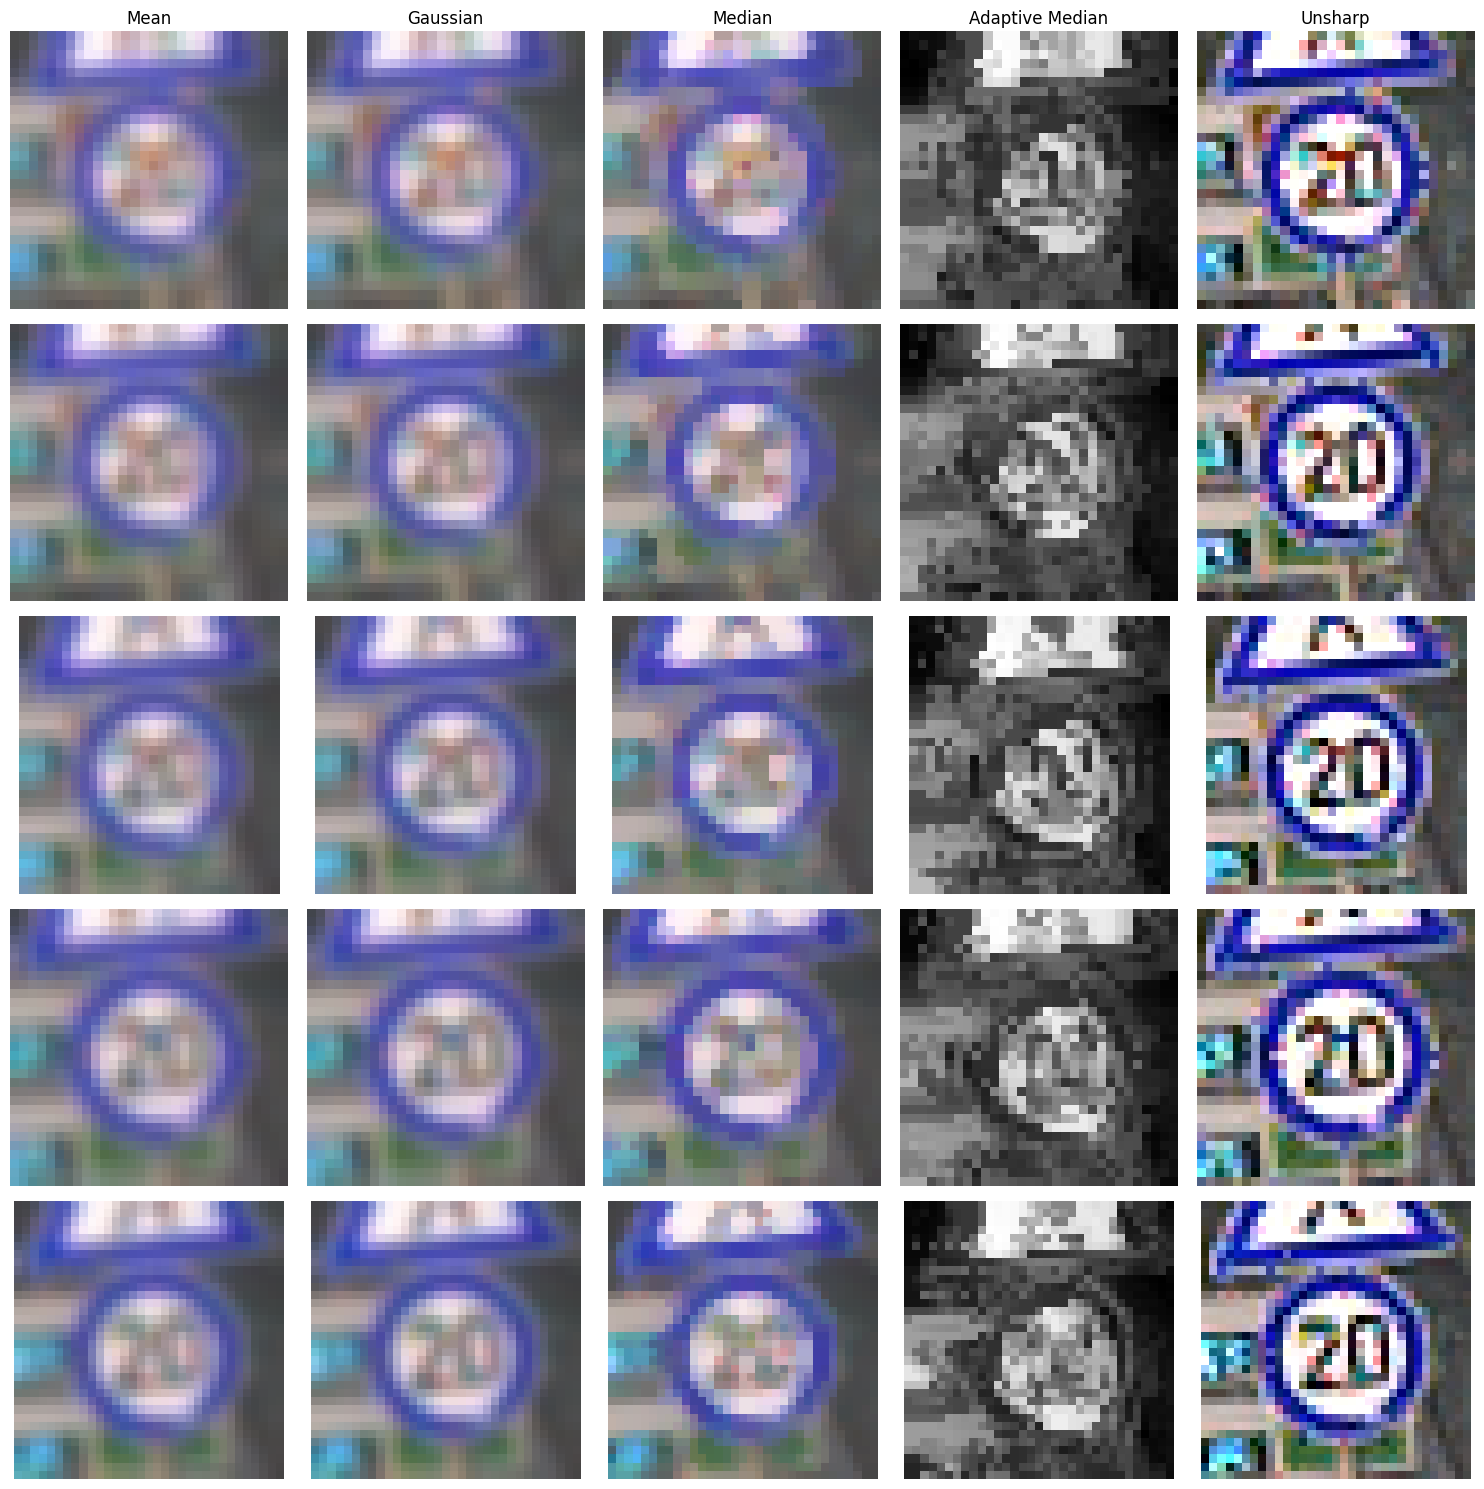

In [ ]:
label = 0  # Class label (string if your dictionary uses strings as keys)
sample_indices = [0, 1, 2, 3, 4]  # Example: show first 5 images of class '0'
filter_names = ['mean', 'gaussian', 'median', 'adaptive_median', 'unsharp']

rows = len(sample_indices)
cols = len(filter_names)

plt.figure(figsize=(cols * 3.5, rows * 3.5))

for row_idx, img_idx in enumerate(sample_indices):
    for col_idx, fname in enumerate(filter_names):
        filtered_img = processed_images[label][fname][img_idx]['filtered_image']
        image_path = processed_images[label][fname][img_idx]['path']
        image_name = image_path.split('/')[-1]  # Get just the filename

        plt_idx = row_idx * cols + col_idx + 1
        plt.subplot(rows, cols, plt_idx)

        # Handle RGB or grayscale
        if filtered_img.ndim == 3 and filtered_img.shape[2] == 3:
            plt.imshow(filtered_img.astype(np.uint8))
        else:
            plt.imshow(filtered_img, cmap='gray')

        # Titles for top row
        if row_idx == 0:
            plt.title(fname.replace('_', ' ').title(), fontsize=10)

        # Labels for bottom of each subplot
        plt.xlabel(f"Image {img_idx} – {image_name}", fontsize=8)
        plt.xticks([]); plt.yticks([])

plt.tight_layout()
plt.show()